# NLP - Disaster Tweets

## Description

This notebook contains the code used for the 'Natural Language Processing with Disaster Tweets' Kaggle competition (link: https://www.kaggle.com/c/nlp-getting-started/overview).

The following description of the competition is taken from the Kaggle wesbite:

*In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified. If this is your first time working on an NLP problem, we've created a quick tutorial to get you up and running.*

## Dataset

The following description of the data used in the competition is taken from the Kaggle website:

*Files:*
- *train.csv - the training set*
- *test.csv - the test set*
- *sample_submission.csv - a sample submission file in the correct format*

*Columns:*
- *id - a unique identifier for each tweet*
- *text - the text of the tweet*
- *location - the location the tweet was sent from (may be blank)*
- *keyword - a particular keyword from the tweet (may be blank)*
- *target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)*


## Import Libraries

In [12]:
import pandas as pd
import numpy as np

import re
import string
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

## Exploratory Data Analysis

### Load data

In [2]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

### Explore Data

Explore the format of the data.

In [3]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
print(f"Size of training set: {len(df_train)}")
print(f"Size of test set: {len(df_test)}")

Size of training set: 7613
Size of test set: 3263


Explore the text field.

In [6]:
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("Length of Text in the Training Set")
print(df_train["length"].describe())
print()

print("Length of Text in the Test Set")
print(df_test["length"].describe())

Length of Text in the Training Set
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Length of Text in the Test Set
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


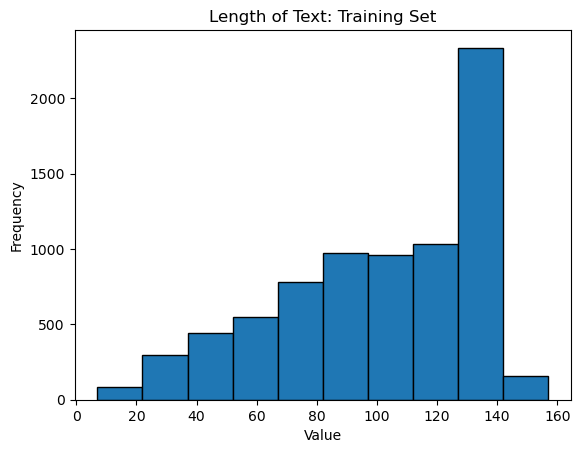

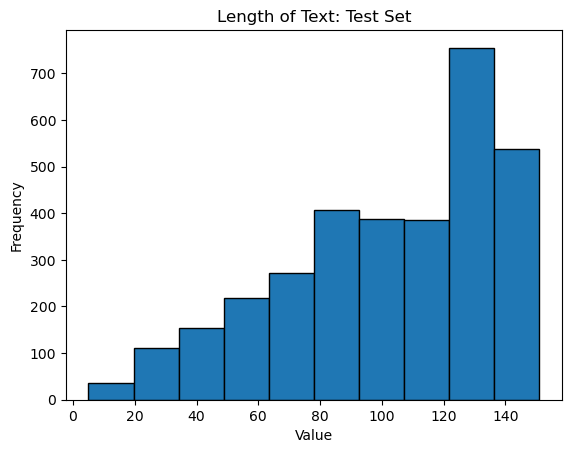

In [7]:
# Create histogram
plt.hist(df_train["length"], bins=10, edgecolor='black')
plt.title('Length of Text: Training Set')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()
                  
# Create histogram
plt.hist(df_test["length"], bins=10, edgecolor='black')
plt.title('Length of Text: Test Set')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

Explore keyword, location, and target field.

In [8]:
print('Number of NA values for location field in training set')
print(df_train['keyword'].isna().sum())
print()
print('Description of keyword field in training set')
print(df_train['keyword'].describe())
print()
print('Number of NA values for keyword field in test set')
print(df_test['keyword'].isna().sum())
print()
print('Description of keyword field in test set')
print(df_test['keyword'].describe())

Number of NA values for location field in training set
61

Description of keyword field in training set
count           7552
unique           221
top       fatalities
freq              45
Name: keyword, dtype: object

Number of NA values for keyword field in test set
26

Description of keyword field in test set
count        3237
unique        221
top       deluged
freq           23
Name: keyword, dtype: object


In [9]:
print('Number of NA values for location field in training set')
print(df_train['location'].isna().sum())
print()
print('Description of location field in training set')
print(df_train['location'].describe())
print()
print('Number of NA values for location field in test set')
print(df_test['location'].isna().sum())
print()
print('Description of location field in test set')
print(df_test['location'].describe())

Number of NA values for location field in training set
2533

Description of location field in training set
count     5080
unique    3341
top        USA
freq       104
Name: location, dtype: object

Number of NA values for location field in test set
1105

Description of location field in test set
count         2158
unique        1602
top       New York
freq            38
Name: location, dtype: object


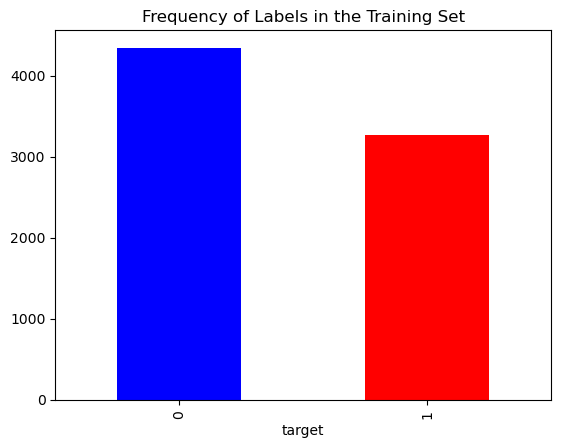

In [10]:
df_train['target'].value_counts().plot(kind = 'bar', color = ['blue', 'red'])
plt.title('Frequency of Labels in the Training Set')
plt.show()

The keyword and location fields are poorly populated. We'll train the model purely on the text field.

## Data Preprocessing

First, clean the text field.
- Remove url
- Remove emoji
- Reomve html
- Remove punctuation
- Make lower case

Based on the following Kaggle submission: https://www.kaggle.com/code/mayayevnin/text-classification-with-llms.

In [14]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)


def clean_text(text):
    # make everything lower case
    text = text.lower()
    
    # remove URLs
    text = remove_url(text)
    
    # remove punctuations
    text = remove_punct(text)
    
    # remove emojis
    text = remove_emoji(text)
    
    # remove stopwords
    sw = stopwords.words('english')
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    text = " ".join(text)
       
    return text


# Clean text
df_train['clean_text'] = df_train['text'].apply(lambda x: clean_text(x))
df_test['clean_text']  = df_test['text'].apply(lambda x: clean_text(x))


# Count the number of unique words in the clean text
def count_words(clmn):
    count = Counter()
    for txt in clmn.values:
        for wrd in txt.split():
            count[wrd] += 1
    return count
counter = count_words(df_train.clean_text)
n_unq_wrds = len(counter)
print("Number of unique words in clean text: ", n_unq_wrds)


# View clean_text field in updated training set
df_train.head()

Number of unique words in clean text:  17971


,id,keyword,location,text,target,length,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,deeds reason earthquake may allah forgive us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,residents asked shelter place notified officer...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,13000 people receive wildfires evacuation orde...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,got sent photo ruby alaska smoke wildfires pou...


Split the training set into a training and validation set.

In [15]:
# Split data into training/validation set
X = df_train['clean_text']
y = df_train['target']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

Tokenize the data.

In [24]:
# Convert to array
X_train = np.array(X_train)
X_val = np.array(X_val)
y_train = np.array(y_train)
y_val = np.array(y_val)
X_test = np.array(df_test['clean_text'])


# Vectorize a text corpus by turning each text into a sequence of integers
tokenizer = Tokenizer(num_words = n_unq_wrds)
tokenizer.fit_on_texts(X_train)


# Convert text data to sequences
train_sequences = tokenizer.texts_to_sequences(X_train)
val_sequences = tokenizer.texts_to_sequences(X_val)
test_sequences = tokenizer.texts_to_sequences(X_test)


# Identify max length
max_length = 0
for tweet in train_sequences:
    max_length = max(max_length, len(tweet))
for tweet in val_sequences:
    max_length = max(max_length, len(tweet))
for tweet in test_sequences:
    max_length = max(max_length, len(tweet))
print('Max sentence length: ', max_length)

Max sentence length:  25


Pad the sequences to have the same length.

In [25]:
# Max number of words in a sequence
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding="post", truncating="post")
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding="post", truncating="post")
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding="post", truncating="post")

Let's take a peak at how this is working.

In [26]:
print(X_train[15])
print(train_sequences[15])
print(train_padded[15])

zojadelin literally almost head collision us today pilot knob
[5652, 547, 548, 176, 399, 13, 57, 1658, 3724]
[5652  547  548  176  399   13   57 1658 3724    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]


## Model Architecture

### Stacked LSTM

LSTM is a type of recurrent neural network that mitigates the vanishing gradient problem. The stacked LSTM allows multiple LSTM layers to be stacked onto one another thereby enabling the model to uncover more complex features of the data.

In [54]:
# Stacked LSTM
model_lstm = keras.models.Sequential()
model_lstm.add(Embedding(input_dim = n_unq_wrds, output_dim = 32, input_length = max_length))
model_lstm.add(LSTM(64, return_sequences=True, dropout=0.2))
model_lstm.add(LSTM(128, return_sequences=True, dropout=0.2))
model_lstm.add(LSTM(256, return_sequences=True, dropout=0.2))
model_lstm.add(LSTM(256))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(128, activation='relu'))
model_lstm.add(Dense(1, activation="sigmoid"))
model_lstm.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_22 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_23 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_24 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_25 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Bidirectional, stacked LSTM

The bidirectional stacked LSTM is a version of LSTM that enables input sequences to be processed from both directions. As such, the model allows for the meaning of words to be based on associations to text both before and after the word. The stacked LSTM allows multiple LSTM layers to be stacked onto one another thereby enabling the model to uncover more complex features of the data.

In [55]:
# Bidirectional + Stacked LSTM
model_bilstm = keras.models.Sequential()
model_bilstm.add(Embedding(input_dim = n_unq_wrds, output_dim = 32, input_length = max_length))
model_bilstm.add(Bidirectional(LSTM(64, return_sequences=True, dropout=0.2)))
model_bilstm.add(Bidirectional(LSTM(128, return_sequences=True, dropout=0.2)))
model_bilstm.add(Bidirectional(LSTM(256, return_sequences=True, dropout=0.2)))
model_bilstm.add(LSTM(256))
model_bilstm.add(Dropout(0.2))
model_bilstm.add(Dense(128, activation='relu'))
model_bilstm.add(Dense(1, activation="sigmoid"))
model_bilstm.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_11 (Bidirectional)     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_12 (Bidirectional)     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_13 (Bidirectional)     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_29 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Compile models

Compile the models. We'll use accuracy as the metric of interest as this is the metric of interest in the Kaggle competition.

In [56]:
# Compile
model_lstm.compile(optimizer = Adam(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])
model_bilstm.compile(optimizer = Adam(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])

### Train models

Train the models. We'll use early stopping in cases where additional epochs have little impact on improving the accuracy.

In [57]:
# Stacked LSTM
history_lstm = model_lstm.fit(train_padded, y_train, 
                              epochs = 10, batch_size = 64, validation_data = (val_padded, y_val))
model_lstm.save("model_lstm.keras")

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 28s 219ms/step - accuracy: 0.5602 - loss: 0.6863 - val_accuracy: 0.5850 - val_loss: 0.6635
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 38s 187ms/step - accuracy: 0.6742 - loss: 0.6106 - val_accuracy: 0.7479 - val_loss: 0.5090
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 20s 207ms/step - accuracy: 0.8048 - loss: 0.4199 - val_accuracy: 0.7787 - val_loss: 0.4717
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 20s 210ms/step - accuracy: 0.8629 - loss: 0.3359 - val_accuracy: 0.7768 - val_loss: 0.5093
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 20s 208ms/step - accuracy: 0.8900 - loss: 0.2778 - val_accuracy: 0.7938 - val_loss: 0.4822
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 20s 209ms/step - accuracy: 0.9094 - loss: 0.2301 - val_accuracy: 0.7925 - val_loss: 0.5043
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 20s 207ms/step - accuracy: 0.9279 - loss: 0.1864 - val_accuracy: 0.7892 - val_loss: 0.6116
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 20s 206ms/step - accuracy: 0.9449 - loss: 0.1508 - val_accu

In [58]:
# Bidirectional, stacked LSTM
history_bilstm = model_bilstm.fit(train_padded, y_train, 
                              epochs = 10, batch_size = 64, validation_data = (val_padded, y_val))
model_bilstm.save("model_bilstm.keras")

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 55s 438ms/step - accuracy: 0.5702 - loss: 0.6857 - val_accuracy: 0.5739 - val_loss: 0.6744
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 42s 437ms/step - accuracy: 0.6033 - loss: 0.6542 - val_accuracy: 0.7275 - val_loss: 0.5470
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 78s 389ms/step - accuracy: 0.8114 - loss: 0.4435 - val_accuracy: 0.7787 - val_loss: 0.4846
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 42s 437ms/step - accuracy: 0.8722 - loss: 0.3250 - val_accuracy: 0.7866 - val_loss: 0.4937
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 39s 410ms/step - accuracy: 0.8974 - loss: 0.2640 - val_accuracy: 0.7853 - val_loss: 0.5005
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 42s 415ms/step - accuracy: 0.9132 - loss: 0.2328 - val_accuracy: 0.7636 - val_loss: 0.6226
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 42s 442ms/step - accuracy: 0.9262 - loss: 0.1875 - val_accuracy: 0.7794 - val_loss: 0.6001
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 46s 477ms/step - accuracy: 0.9475 - loss: 0.1441 - val_accu

## Results and Analysis

Now that the models have been trained, let's visualize their accuracy over epochs.

In [59]:
def create_plot(trained_model, title):
    plt.figure(figsize = (12, 4))
    plt.plot(trained_model.history['accuracy'], label='Training Set')
    plt.plot(trained_model.history['val_accuracy'], label='Validation Set')
    plt.title(f'{title} - Accuracy')
    plt.legend()
    plt.show()

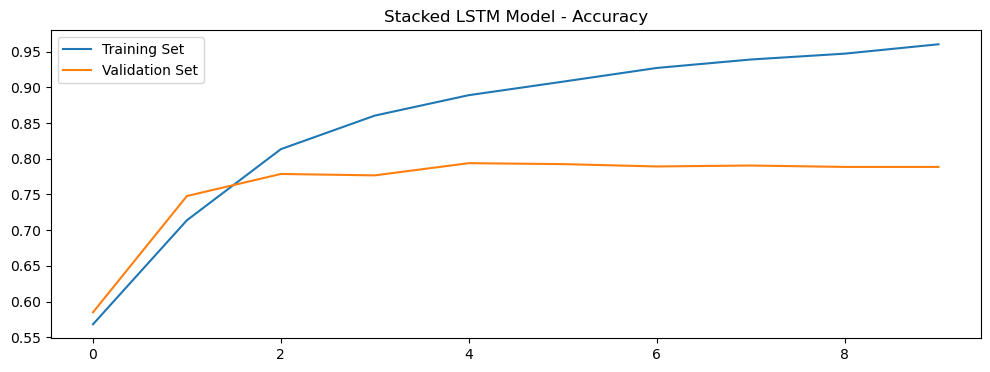

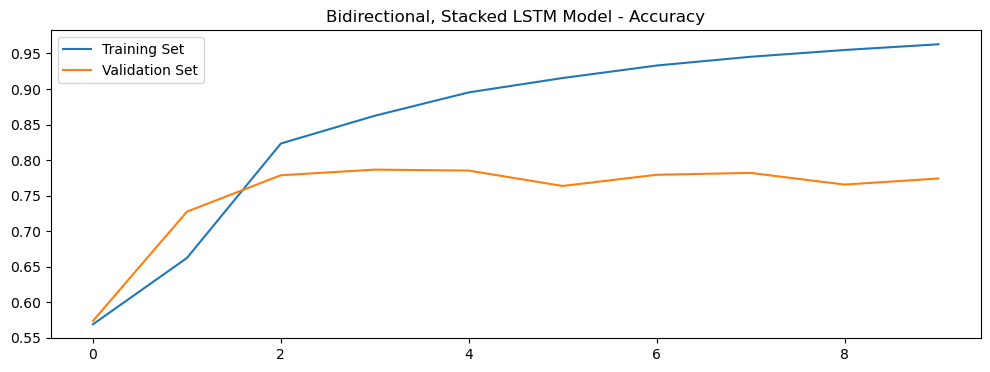

In [60]:
create_plot(history_lstm, 'Stacked LSTM Model')
create_plot(history_bilstm, 'Bidirectional, Stacked LSTM Model')

In [62]:
loss_lstm, acc_lstm = model_lstm.evaluate(val_padded, y_val)
loss_bilstm, acc_bilstm = model_bilstm.evaluate(val_padded, y_val)
print("The accuracy in the LSTM stacked model was: ", acc_lstm)
print("The loss in the LSTM stacked model was: ", loss_lstm)
print("The accuracy in the bidirectional LSTM stacked model was: ", acc_bilstm)
print("The loss in the bidirectional LSTM stacked model was: ", loss_bilstm)

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.7697 - loss: 0.7528
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.7550 - loss: 0.7796
The accuracy in the LSTM stacked model was:  0.7885751724243164
The loss in the LSTM stacked model was:  0.6760676503181458
The accuracy in the bidirectional LSTM stacked model was:  0.7741299867630005
The loss in the bidirectional LSTM stacked model was:  0.7141118049621582


Looks like both models had comparable, good performance. However, the accuracy in the validation set was better in the slightly better in the LSTM stacked model as compared to the bidirectional model (0.789 vs. 0.774). As such, we'll focus on the unidirectional LSTM stacked model moving forward.

### Hyperparameter Tuning

Next, let's explore the impact of hyperparameter tuning on the model.

Based on our evaluation of the three models above, we have already observed the impact of the following:
- Number of epochs: using a higher number of epochs during training appeared to increase the accuracy of the model in both the training and validation sets.

Now, let's test the impact of modifying the following hyperparameters:
- Number of layers/neurons: What happens if we remove layers and reduce the number of neurons?
- Dropout: What happens if we increase dropout?
- Batch size: What happens using a batch size of 32 vs. 64 (default) vs. 64)
- Learning rate: What happens if we change the learning rate from 0.001 (default) to 0.05

#### Hyperparameter Tuning: Number of layers/neurons

Test the impact of reducing the number of layers/neurons.

In [63]:
# Stacked LSTM
model_lstm_fewerlayers = keras.models.Sequential()
model_lstm_fewerlayers.add(Embedding(input_dim = n_unq_wrds, output_dim = 32, input_length = max_length))
model_lstm_fewerlayers.add(LSTM(64, return_sequences=True, dropout=0.2))
model_lstm_fewerlayers.add(LSTM(128, return_sequences=True, dropout=0.2))
# model_lstm_fewerlayers.add(LSTM(256, return_sequences=True, dropout=0.2))
# model_lstm_fewerlayers.add(LSTM(256))
model_lstm_fewerlayers.add(LSTM(128))
model_lstm_fewerlayers.add(Dropout(0.2))
model_lstm_fewerlayers.add(Dense(128, activation='relu'))
model_lstm_fewerlayers.add(Dense(1, activation="sigmoid"))
model_lstm_fewerlayers.summary()

# Compile
model_lstm_fewerlayers.compile(optimizer = Adam(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])

# Fit
history_lstm_fewerlayers = model_lstm_fewerlayers.fit(train_padded, y_train, epochs = 10, batch_size = 64, 
                                                      validation_data = (val_padded, y_val))

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_30 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_31 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_32 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 17s 100ms/step - accuracy: 0.5480 - loss: 0.6892 - val_accuracy: 0.5739 - val_loss: 0.6767
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.5843 - loss: 0.6722 - val_accuracy: 0.7380 - val_loss: 0.5979
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - accuracy: 0.7923 - loss: 0.4609 - val_accuracy: 0.7708 - val_loss: 0.5022
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - accuracy: 0.8558 - loss: 0.3428 - val_accuracy: 0.7800 - val_loss: 0.4746
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - accuracy: 0.8796 - loss: 0.2901 - val_accuracy: 0.7873 - val_loss: 0.5231
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - accuracy: 0.9116 - loss: 0.2298 - val_accuracy: 0.7846 - val_loss: 0.5178
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 17s 80ms/step - accuracy: 0.9256 - loss: 0.1989 - val_accuracy: 0.7820 - val_loss: 0.5686
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.9448 - loss: 0.1535 - val_accuracy: 0.7

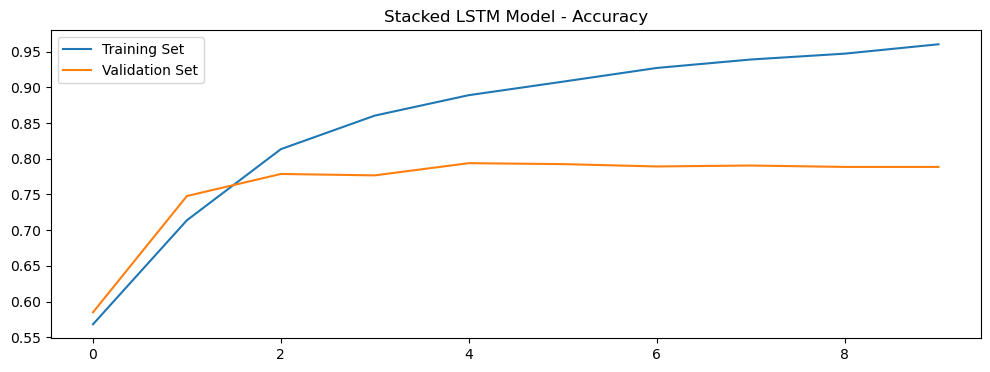

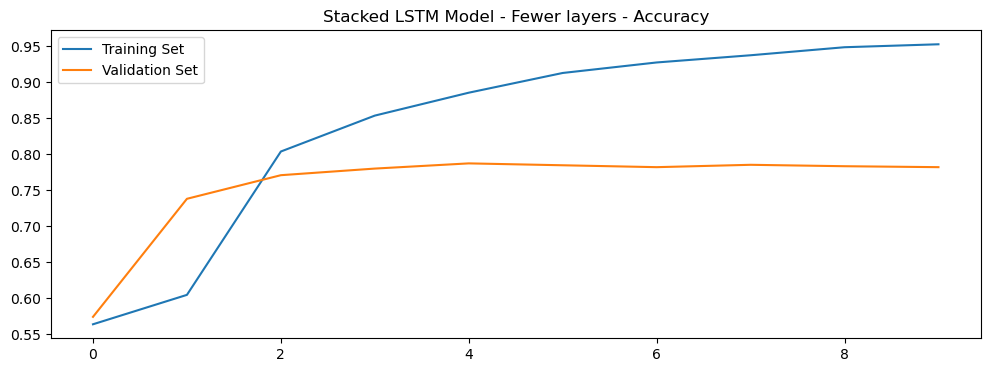

In [67]:
create_plot(history_lstm, 'Stacked LSTM Model')
create_plot(history_lstm_fewerlayers, 'Stacked LSTM Model - Fewer layers')

In [65]:
# loss_lstm, acc_lstm = model_lstm.evaluate(val_padded, y_val)
loss_lstm_fl, acc_lstm_fl = model_lstm_fewerlayers.evaluate(val_padded, y_val)
print("The accuracy in the LSTM stacked model was: ", acc_lstm)
print("The loss in the LSTM stacked model was: ", loss_lstm)
print("The accuracy in the LSTM stacked model with fewer layers/neurons was: ", acc_lstm_fl)
print("The loss in the LSTM stacked model with fewer layers/neurons was: ", loss_lstm_fl)

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7691 - loss: 0.7708
The accuracy in the LSTM stacked model was:  0.7885751724243164
The loss in the LSTM stacked model was:  0.6760676503181458
The accuracy in the bidirectional LSTM stacked model was:  0.7820091843605042
The loss in the bidirectional LSTM stacked model was:  0.7119659185409546


Looks like the difference in the accuracy in the validation set in the model with fewer layers/neurons was comparable to the original model. This finding suggests a simpler model is sufficient to detect associations between words to classify the tweets.

#### Hyperparameter Tuning: Dropout

Let's test the impact of increasing the dropout rate from 20% to 30% at each layer. We know that including dropout improves performance, but what happens if we increase it?

In [66]:
# Stacked LSTM
model_lstm_greaterdropout = keras.models.Sequential()
model_lstm_greaterdropout.add(Embedding(input_dim = n_unq_wrds, output_dim = 32, input_length = max_length))
model_lstm_greaterdropout.add(LSTM(64, return_sequences=True, dropout=0.3))
model_lstm_greaterdropout.add(LSTM(128, return_sequences=True, dropout=0.3))
model_lstm_greaterdropout.add(LSTM(256, return_sequences=True, dropout=0.3))
model_lstm_greaterdropout.add(LSTM(256))
model_lstm_greaterdropout.add(Dropout(0.3))
model_lstm_greaterdropout.add(Dense(128, activation='relu'))
model_lstm_greaterdropout.add(Dense(1, activation="sigmoid"))
model_lstm_greaterdropout.summary()

# Compile
model_lstm_greaterdropout.compile(optimizer = Adam(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])

# Fit
history_lstm_greaterdropout = model_lstm_greaterdropout.fit(train_padded, y_train, epochs = 10, batch_size = 64, 
                                                      validation_data = (val_padded, y_val))

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_33 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_34 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_35 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_36 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 34s 256ms/step - accuracy: 0.5789 - loss: 0.6868 - val_accuracy: 0.5739 - val_loss: 0.6769
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 39s 227ms/step - accuracy: 0.5792 - loss: 0.6746 - val_accuracy: 0.6586 - val_loss: 0.6185
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 24s 248ms/step - accuracy: 0.7398 - loss: 0.5337 - val_accuracy: 0.7761 - val_loss: 0.4882
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 22s 227ms/step - accuracy: 0.8265 - loss: 0.4110 - val_accuracy: 0.7820 - val_loss: 0.4919
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 42s 232ms/step - accuracy: 0.8688 - loss: 0.3252 - val_accuracy: 0.7853 - val_loss: 0.4620
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 22s 232ms/step - accuracy: 0.8844 - loss: 0.2950 - val_accuracy: 0.7840 - val_loss: 0.5224
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 23s 241ms/step - accuracy: 0.8979 - loss: 0.2530 - val_accuracy: 0.7912 - val_loss: 0.4980
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 38s 209ms/step - accuracy: 0.9149 - loss: 0.2167 - val_accu

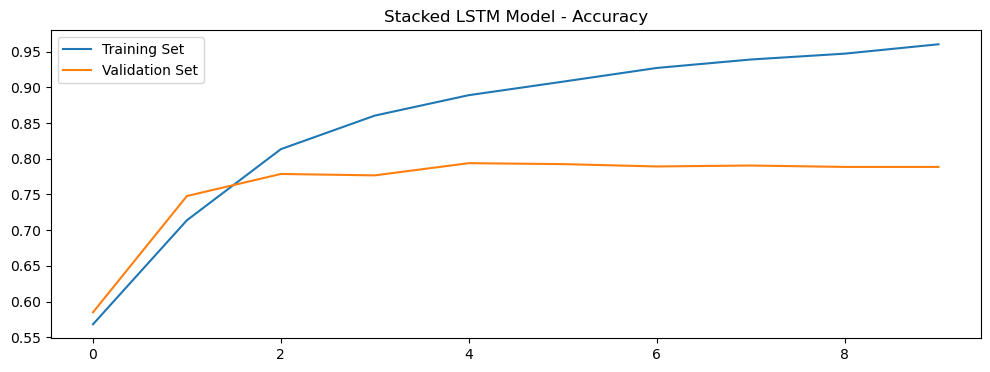

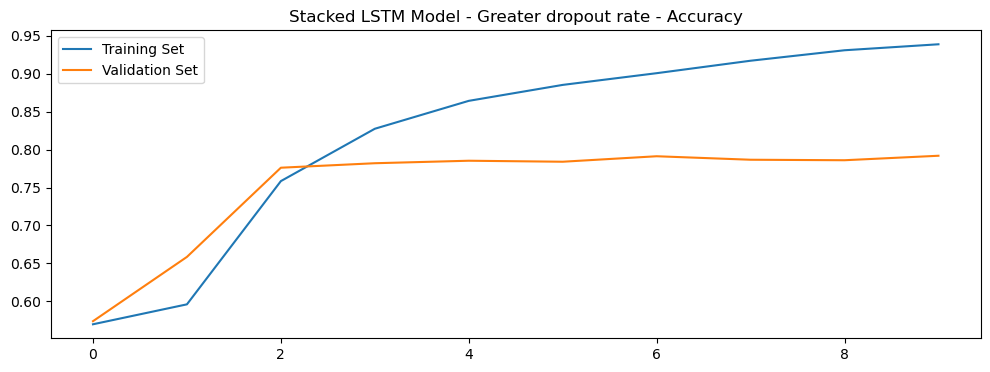

In [69]:
create_plot(history_lstm, 'Stacked LSTM Model')
create_plot(history_lstm_greaterdropout, 'Stacked LSTM Model - Greater dropout rate')

In [70]:
# loss_lstm, acc_lstm = model_lstm.evaluate(val_padded, y_val)
loss_lstm_gd, acc_lstm_gd = model_lstm_greaterdropout.evaluate(val_padded, y_val)
print("The accuracy in the LSTM stacked model was: ", acc_lstm)
print("The loss in the LSTM stacked model was: ", loss_lstm)
print("The accuracy in the LSTM stacked model with a greater dropout rate was: ", acc_lstm_gd)
print("The loss in the LSTM stacked model with a greater dropout rate was: ", loss_lstm_gd)

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.7690 - loss: 0.6949
The accuracy in the LSTM stacked model was:  0.7885751724243164
The loss in the LSTM stacked model was:  0.6760676503181458
The accuracy in the LSTM stacked model with a greater dropout rate was:  0.7918581962585449
The loss in the LSTM stacked model with a greater dropout rate was:  0.618584930896759


Increasing the dropout rate from 20% to 30% led to a marginal improvement in the accuracy in the validation set. These findings are likely insignificant but may reflect some overfitting in the model.

#### Hyperparameter Tuning: Batch Size

Let's test the impact of changing the batch size from 64 (default) to 32 or 128.

In [72]:
# Stacked LSTM
model_lstm_32 = keras.models.Sequential()
model_lstm_32.add(Embedding(input_dim = n_unq_wrds, output_dim = 32, input_length = max_length))
model_lstm_32.add(LSTM(64, return_sequences=True, dropout=0.2))
model_lstm_32.add(LSTM(128, return_sequences=True, dropout=0.2))
model_lstm_32.add(LSTM(256, return_sequences=True, dropout=0.2))
model_lstm_32.add(LSTM(256))
model_lstm_32.add(Dropout(0.2))
model_lstm_32.add(Dense(128, activation='relu'))
model_lstm_32.add(Dense(1, activation="sigmoid"))
model_lstm_32.summary()

# Stacked LSTM
model_lstm_128 = keras.models.Sequential()
model_lstm_128.add(Embedding(input_dim = n_unq_wrds, output_dim = 32, input_length = max_length))
model_lstm_128.add(LSTM(64, return_sequences=True, dropout=0.2))
model_lstm_128.add(LSTM(128, return_sequences=True, dropout=0.2))
model_lstm_128.add(LSTM(256, return_sequences=True, dropout=0.2))
model_lstm_128.add(LSTM(256))
model_lstm_128.add(Dropout(0.2))
model_lstm_128.add(Dense(128, activation='relu'))
model_lstm_128.add(Dense(1, activation="sigmoid"))
model_lstm_128.summary()

# Compile
model_lstm_32.compile(optimizer = Adam(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])
model_lstm_128.compile(optimizer = Adam(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])

# Fit
history_lstm_32 = model_lstm_32.fit(train_padded, y_train, epochs = 10, batch_size = 32, 
                                                      validation_data = (val_padded, y_val))
history_lstm_128 = model_lstm_128.fit(train_padded, y_train, epochs = 10, batch_size = 128, 
                                                      validation_data = (val_padded, y_val))

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_15 (Embedding)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_45 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_46 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_47 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_48 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_16 (Embedding)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_49 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_50 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_51 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_52 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 40s 162ms/step - accuracy: 0.5603 - loss: 0.6849 - val_accuracy: 0.7052 - val_loss: 0.5823
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 32s 166ms/step - accuracy: 0.7528 - loss: 0.5276 - val_accuracy: 0.7741 - val_loss: 0.4870
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 33s 172ms/step - accuracy: 0.8332 - loss: 0.3836 - val_accuracy: 0.7886 - val_loss: 0.4911
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 35s 186ms/step - accuracy: 0.8857 - loss: 0.2944 - val_accuracy: 0.7912 - val_loss: 0.5277
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 37s 161ms/step - accuracy: 0.9136 - loss: 0.2262 - val_accuracy: 0.7932 - val_loss: 0.5087
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 38s 143ms/step - accuracy: 0.9331 - loss: 0.1897 - val_accuracy: 0.7617 - val_loss: 0.6101
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 28s 144ms/step - accuracy: 0.9424 - loss: 0.1559 - val_accuracy: 0.7879 - val_loss: 0.6512
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 28s 145ms/step - accuracy: 0.9485 - loss: 0

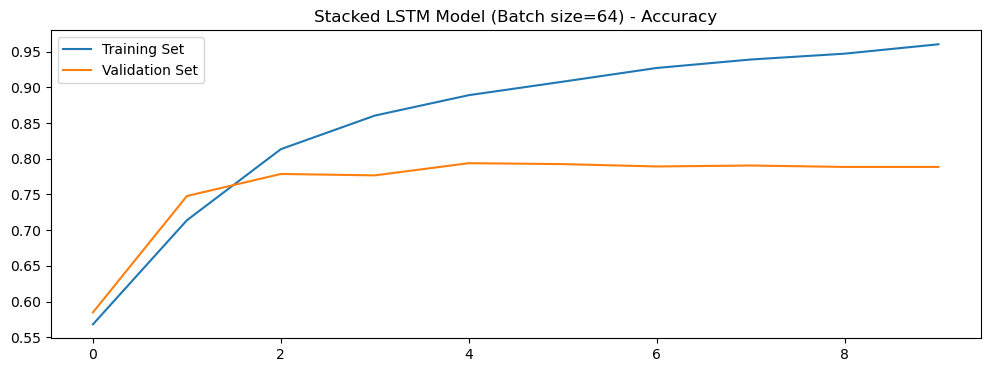

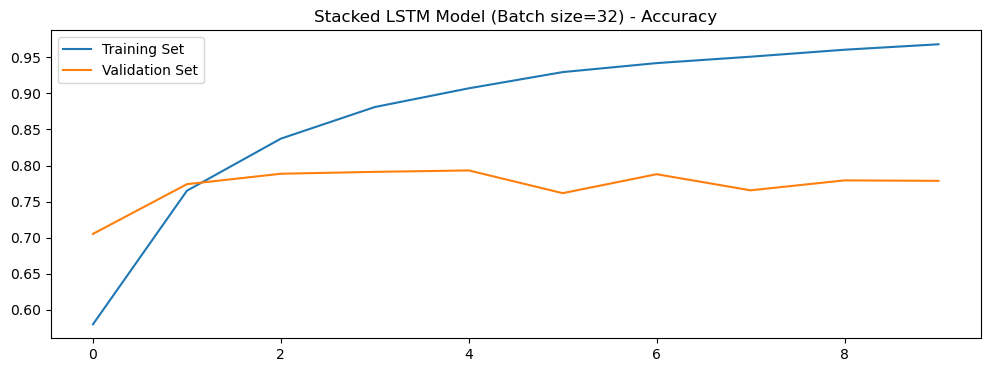

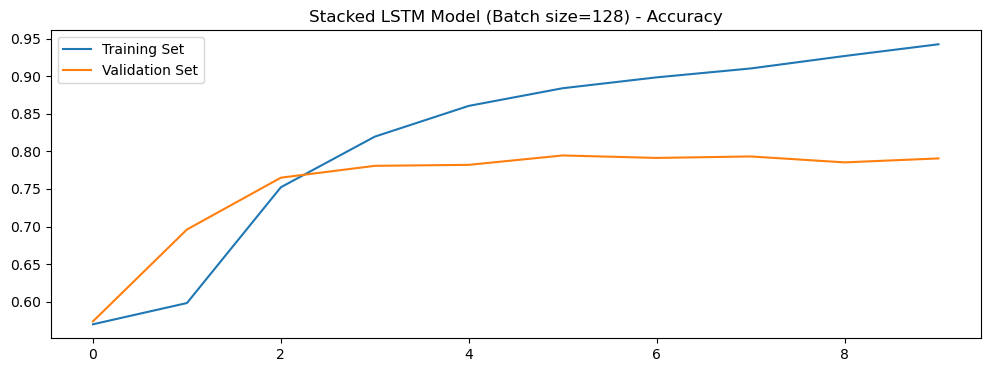

In [73]:
create_plot(history_lstm, 'Stacked LSTM Model (Batch size=64)')
create_plot(history_lstm_32, 'Stacked LSTM Model (Batch size=32)')
create_plot(history_lstm_128, 'Stacked LSTM Model (Batch size=128)')

In [74]:
# loss_lstm, acc_lstm = model_lstm.evaluate(val_padded, y_val)
loss_lstm_32, acc_lstm_32 = model_lstm_32.evaluate(val_padded, y_val)
loss_lstm_128, acc_lstm_128 = model_lstm_128.evaluate(val_padded, y_val)
print("The accuracy in the LSTM stacked model with a batch size of 64 was: ", acc_lstm)
print("The loss in the LSTM stacked model with a batch size of 64  was: ", loss_lstm)
print("The accuracy in the LSTM stacked model with  a batch size of 32  was: ", acc_lstm_32)
print("The loss in the LSTM stacked model with a batch size of 32  was: ", loss_lstm_32)
print("The accuracy in the LSTM stacked model with  a batch size of 128  was: ", acc_lstm_128)
print("The loss in the LSTM stacked model with a batch size of 128  was: ", loss_lstm_128)

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.7463 - loss: 0.8187
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.7817 - loss: 0.6904
The accuracy in the LSTM stacked model with a batch size of 64 was:  0.7885751724243164
The loss in the LSTM stacked model with a batch size of 64  was:  0.6760676503181458
The accuracy in the LSTM stacked model with  a batch size of 32  was:  0.7787262201309204
The loss in the LSTM stacked model with a batch size of 32  was:  0.7252669334411621
The accuracy in the LSTM stacked model with  a batch size of 128  was:  0.7905449867248535
The loss in the LSTM stacked model with a batch size of 128  was:  0.6402069330215454


As indicated by the accuracy in the validation set, it seems that the performance of the model improved modestly as batch size increased.

#### Hyperparameter Tuning: Learning Rate

Let's test what happens when the learning rate is increased from 0.0001 (default) to 0.05.

In [76]:
# Stacked LSTM
model_lstm_tr = keras.models.Sequential()
model_lstm_tr.add(Embedding(input_dim = n_unq_wrds, output_dim = 32, input_length = max_length))
model_lstm_tr.add(LSTM(64, return_sequences=True, dropout=0.2))
model_lstm_tr.add(LSTM(128, return_sequences=True, dropout=0.2))
model_lstm_tr.add(LSTM(256, return_sequences=True, dropout=0.2))
model_lstm_tr.add(LSTM(256))
model_lstm_tr.add(Dropout(0.2))
model_lstm_tr.add(Dense(128, activation='relu'))
model_lstm_tr.add(Dense(1, activation="sigmoid"))
model_lstm_tr.summary()

# Compile
model_lstm_tr.compile(optimizer = Adam(learning_rate=0.05), loss = 'binary_crossentropy', metrics = ['accuracy'])

# Fit
history_lstm_tr = model_lstm_tr.fit(train_padded, y_train, epochs = 10, batch_size = 64, 
                                                      validation_data = (val_padded, y_val))

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_18 (Embedding)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_57 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_58 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_59 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_60 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 31s 217ms/step - accuracy: 0.5332 - loss: 2.0042 - val_accuracy: 0.5739 - val_loss: 0.6818
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 21s 216ms/step - accuracy: 0.5701 - loss: 0.6829 - val_accuracy: 0.4865 - val_loss: 0.6889
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 21s 219ms/step - accuracy: 0.5629 - loss: 0.6832 - val_accuracy: 0.5739 - val_loss: 0.6836
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 39s 197ms/step - accuracy: 0.5742 - loss: 0.6826 - val_accuracy: 0.5739 - val_loss: 0.6848
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 22s 228ms/step - accuracy: 0.5717 - loss: 0.6836 - val_accuracy: 0.5739 - val_loss: 0.6838
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 21s 219ms/step - accuracy: 0.5679 - loss: 0.6856 - val_accuracy: 0.5739 - val_loss: 0.6824
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 39s 198ms/step - accuracy: 0.5613 - loss: 0.6870 - val_accuracy: 0.5739 - val_loss: 0.6822
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 21s 218ms/step - accuracy: 0.5751 - loss: 0.6826 - val_accu

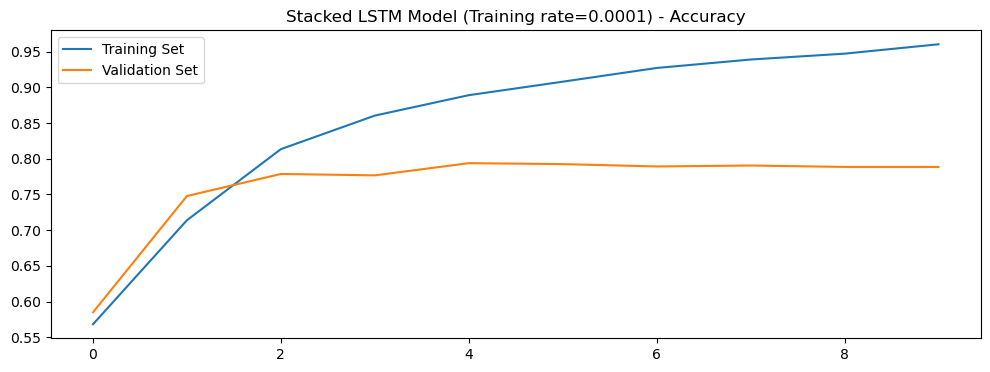

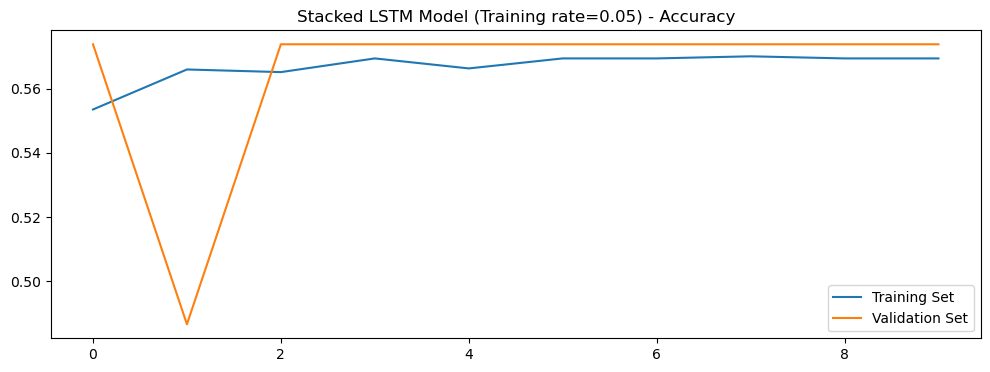

In [77]:
create_plot(history_lstm, 'Stacked LSTM Model (Training rate=0.0001)')
create_plot(history_lstm_tr, 'Stacked LSTM Model (Training rate=0.05)')

In [78]:
# loss_lstm, acc_lstm = model_lstm.evaluate(val_padded, y_val)
loss_lstm_tr, acc_lstm_tr = model_lstm_tr.evaluate(val_padded, y_val)
print("The accuracy in the LSTM stacked model with a training rate of 0.0001 was: ", acc_lstm)
print("The loss in the LSTM stacked model with a training rate of 0.0001 was: ", loss_lstm)
print("The accuracy in the LSTM stacked model with a training rate of 0.05 was ", acc_lstm_tr)
print("The loss in the LSTM stacked model with a training rate of 0.05 was ", loss_lstm_tr)

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.5694 - loss: 0.6837
The accuracy in the LSTM stacked model with a training rate of 0.0001 was:  0.7885751724243164
The loss in the LSTM stacked model with a training rate of 0.0001 was:  0.6760676503181458
The accuracy in the LSTM stacked model with a training rate of 0.05 was  0.5738673806190491
The loss in the LSTM stacked model with a training rate of 0.05 was  0.6826539039611816


Looks like a small increase in the training rate led to a significant decrease in the accuracy in the validation set. This suggests that the increase in the training rate was too large for the model to converge to an optimal solution.

## Results on Test Set

Let's review the format required for the submission.

In [81]:
df_ss = pd.read_csv("data/sample_submission.csv")
df_ss.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


Prepare submission.

In [91]:
pred = model_lstm.predict(test_padded, verbose = 1)
pred_labels = (pred > 0.5).astype(int)

102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step


In [92]:
df_submission = df_test[['id']]
df_submission['target'] = pred_labels
df_submission.head()

C:\Users\steph\AppData\Local\Temp\ipykernel_20264\2264090868.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_submission['target'] = pred_labels


,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,1


In [94]:
# Save data for submission to csv
df_submission.to_csv('submission.csv', index = False)

The public score of the submission to Kaggle is 0.77934, which reflects the accuracy in the test set. This score is very similar to the accuracy observed from the model on the validation set.

## Conclusion

In this project, we built a machine learning model to predict what tweets are associated to natural disasters. Specfically, we trained a stacked LSTM model, a type of recurrent neural network. The model performed fairly as indicated by an accuracy of 0.77934 in the test set.

A few key takeaways learned from observations made during the project:
- A bidrectional LSTM model had comparable performance (or slightly lower) compared to a unidirectional model
- Model performance was comparable even after stripping away layers and reducing the number of neurons in remaining layers
- Increasing batch size was associated with improved performance
- Increasing the learning rate to 0.05 (from 0.0001) was associated with decreased performance
- Increasing the dropout rate appeared to be associated with improved performance in the test set

These findings suggest that machine learning models indeed can be used to categorize tweets about natural disasters. In fact, a model of moderate complexity (e.g., with fewer neurons/layers) may be sufficient to accomplish this task.